In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import  r2_score, mean_absolute_error, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

# Preparing X and Y variables

In [2]:
df = pd.read_csv('data/stud.csv')

In [3]:
df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [7]:
x = df.drop(columns=['math_score'],axis=1)
# drop the math column from the data set and store the dataset in X/
# they represent the independent variables.(can choose anything like reading_score, writing_score or even total or average) - but it is a numerical feature
#axis = 1 specifies the direction - vertical (columns). 0 - horizontal direction (rows)

In [5]:
x.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,74
1,female,group C,some college,standard,completed,90,88
2,female,group B,master's degree,standard,none,95,93
3,male,group A,associate's degree,free/reduced,none,57,44
4,male,group C,some college,standard,none,78,75


In [8]:
y = df['math_score']
# dependent variable

In [9]:
y

0      72
1      69
2      90
3      47
4      76
       ..
995    88
996    62
997    59
998    68
999    77
Name: math_score, Length: 1000, dtype: int64

# Data Pipelines
Data preprocessing pipelines automate the transformation of raw data into a consistent, analysis-ready format through a series of chained operations.

steps:
1) Raw Data: You start with your messy, real-world data.

2) Pipeline Stages: You create a sequence of steps:
   . Imputation: Fill in missing values.

   . Encoding: Convert categorical features into numerical form.

   . Scaling: Normalize or standardize numerical features.

   . Feature Engineering: Create new features from existing ones.

   . Dimensionality Reduction: Reduce the number of features.

3) Automated Execution: The pipeline automatically applies these steps in sequence to the raw data.

4) Clean Data: You end up with transformed data ready for analysis or model training

# OneHotEncoder

 It lets machine learning algorithms work with categorical data by converting it into a numerical format they understand.

  It avoids implying any order or ranking between categories, which could mislead your models.

# StandardScaler

StandardScaler transforms your data so that it has a mean (average) of 0 and a standard deviation of 1.

1) Calculate the Mean: Find the average value of your feature column (e.g., average age, average salary).

2) Calculate the Standard Deviation: Measure how spread out the values are from the mean.

3) Standardize Each Value:

   . Subtract the mean from each individual value.
   . Divide the result by the standard deviation.

# Column Transformer

It allows applying different data transformations to different columns in a dataset, all within a streamlined workflow. It's particularly useful when there is a mix of numerical and categorical features that require separate preprocessing steps.

It basically combines the encoding and scaling of categorical and numerical data into one operation (encoding first then scaling else it might lead to data leakage or mixing of data)

1) Divide and Conquer: Group columns based on the type of transformation they need (e.g., numerical features for scaling, categorical features for one-hot encoding).

2) Create Transformers: Define the specific transformations to apply to each group. Eg:

   . numerical_transformer: A pipeline with StandardScaler to standardize numerical features.

   . categorical_transformer: A pipeline with OneHotEncoder to encode categorical features.

3) Use ColumnTransformer: Create a ColumnTransformer object and specify:

   . Name for each transformation: Give each transformer a descriptive name (e.g., 'num', 'cat'). 

   . The transformer: Assign the appropriate transformer  
   (numerical_transformer, categorical_transformer) to each name.
   
   . The columns: List the columns that each transformer should be applied to

In [16]:
# create Column Transformer with 3 types of Transformers

num_features = x.select_dtypes(exclude="O").columns
cat_features = x.select_dtypes(include="object").columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler() 
one_hot_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder",one_hot_transformer,cat_features),
        ("StandardScaler",numeric_transformer,num_features),
    ]
)

In [17]:
x = preprocessor.fit_transform(x)

In [18]:
x

array([[ 1.        ,  0.        ,  0.        , ...,  1.        ,
         0.19399858,  0.39149181],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         1.42747598,  1.31326868],
       [ 1.        ,  0.        ,  0.        , ...,  1.        ,
         1.77010859,  1.64247471],
       ...,
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.12547206, -0.20107904],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.60515772,  0.58901542],
       [ 1.        ,  0.        ,  0.        , ...,  1.        ,
         1.15336989,  1.18158627]])

In [19]:
x.shape

(1000, 19)

In [24]:
# spliting dataset into train and test

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

x_train.shape, x_test.shape, y_train.shape , y_test.shape

((800, 19), (200, 19), (800,), (200,))

Create an Evaluation Function to give all metrics after model training

In [33]:
def evaluate_model(original, predicted):
    mae = mean_absolute_error(original, predicted)
    rmse = np.sqrt(mean_squared_error(original, predicted))
    r2score = r2_score(original, predicted)

    return mae, rmse, r2score



In [43]:
models = {
    "linear regression": LinearRegression(),
    "lasso": Lasso(),
    "ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "xgbRegressor": XGBRegressor(),
    "catboostRegressor": CatBoostRegressor(),
    "adaboost regressor": AdaBoostRegressor()
}

model_list = []
r2_list = []

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(x_train, y_train) # model training

    # make predictions
    y_train_predict = model.predict(x_train)
    y_test_predict = model.predict(x_test)

    # Evaluate Train and test datasets

    model_train_mae, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_predict)
    model_test_mae, model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_predict)

    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])

    print("Model performance for Training Dataset:")
    print("RMSE: {:.4f}".format(model_train_rmse))
    print("MAE: {:.4f}".format(model_train_mae))
    print("R2 SCORE: {:.4f}".format(model_train_r2))

    print("-"*35)

    print("Model performance for Testing Dataset:")
    print("RMSE: {:.4f}".format(model_test_rmse))
    print("MAE: {:.4f}".format(model_test_mae))
    print("R2 SCORE: {:.4f}".format(model_test_r2))

    r2_list.append(model_test_r2)

    print("="*35)
    print("\n")


    

linear regression
Model performance for Training Dataset:
RMSE: 5.3274
MAE: 4.2788
R2 SCORE: 0.8741
-----------------------------------
Model performance for Testing Dataset:
RMSE: 5.4096
MAE: 4.2259
R2 SCORE: 0.8797


lasso
Model performance for Training Dataset:
RMSE: 6.5938
MAE: 5.2063
R2 SCORE: 0.8071
-----------------------------------
Model performance for Testing Dataset:
RMSE: 6.5197
MAE: 5.1579
R2 SCORE: 0.8253


ridge
Model performance for Training Dataset:
RMSE: 5.3233
MAE: 4.2650
R2 SCORE: 0.8743
-----------------------------------
Model performance for Testing Dataset:
RMSE: 5.3904
MAE: 4.2111
R2 SCORE: 0.8806


K-Neighbors Regressor
Model performance for Training Dataset:
RMSE: 5.7122
MAE: 4.5187
R2 SCORE: 0.8553
-----------------------------------
Model performance for Testing Dataset:
RMSE: 7.2516
MAE: 5.6160
R2 SCORE: 0.7839


Decision Tree Regressor
Model performance for Training Dataset:
RMSE: 0.2795
MAE: 0.0187
R2 SCORE: 0.9997
-----------------------------------
Mo

In [ ]:
#zip combines model names and r2 scores in a way that Pandas DataFrames can easily understand and use to create a well-structured table for analysis
# the zip returns an iterator whose values are stored in a list
pd.DataFrame(list(zip(model_list, r2_list)), columns=["Model Name","R2_Score"]).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
2,ridge,0.880593
0,linear regression,0.879740
5,Random Forest Regressor,0.854755
7,catboostRegressor,0.851632
8,adaboost regressor,0.850605
6,xgbRegressor,0.827797
1,lasso,0.825320
3,K-Neighbors Regressor,0.783898
4,Decision Tree Regressor,0.748272


# linear Regression

In [50]:
lin_model = LinearRegression(fit_intercept=True)
lin_model = lin_model.fit(x_train,y_train)
y_predict = lin_model.predict(x_test)
score = r2_score(y_test, y_predict)*100
print("Accuracy of the model is %.2f" %score)

Accuracy of the model is 87.97


# Plot y_predict and y_test

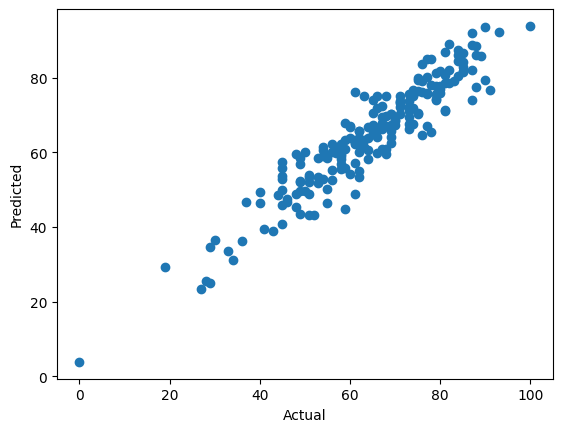

In [52]:
plt.scatter(y_test,y_predict)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()
# if data points are closer to diagonal the good prediction and vice versa

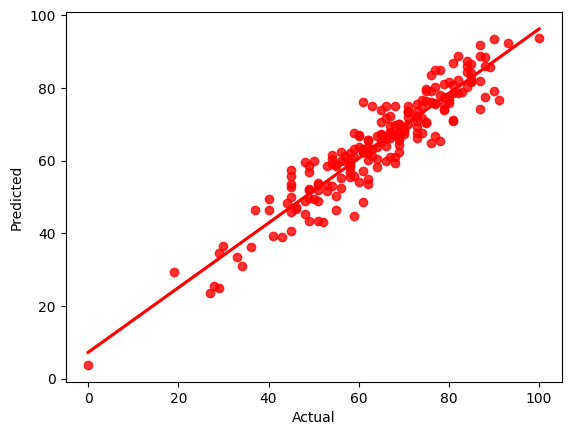

In [56]:
sns.regplot(x=y_test,y=y_predict,ci =None, color="red")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

Difference between Actual and Predicted Values

In [66]:
from operator import index


pred_df = pd.DataFrame({'Actual Value': y_test,'Predicted Value': y_predict, 'difference': y_test-y_predict})
pred_df

,Actual Value,Predicted Value,difference
521,91,76.703125,14.296875
737,53,58.578125,-5.578125
740,80,76.828125,3.171875
660,74,76.734375,-2.734375
411,84,87.484375,-3.484375
...,...,...,...
408,52,43.125000,8.875000
332,62,62.109375,-0.109375
208,74,67.562500,6.437500
613,65,67.328125,-2.328125
